In [5]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
import pandas as pd
import numpy as np
from glob import glob
from tqdm import tqdm
from src.config import *
from src.prediction_functions import *
from sklearn.metrics import roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects
from src.prediction_functions.MatrixMultiplicationMemoryEffectiveChunks import estimation_with_zscore_calculation_in_chunks as estimate_receptor_activity


### Cytokine mapping

In [7]:
genenames = pd.read_excel('data/immunedict/41586_2023_6816_MOESM3_ESM.xlsx')
genenames = genenames[['Cytokine', 'Human gene symbol']].dropna()
genenames_mapping = genenames.set_index('Human gene symbol')['Cytokine'].to_dict()
inv_genenames_mapping = {v: k for k, v in genenames_mapping.items()}

In [8]:
inv_genenames_mapping['41BBL'] = 'TNFSF9'
inv_genenames_mapping['IGF-I'] = 'IGF1' # IGF-I instead of IGF-1 
inv_genenames_mapping['ADSF (Resistin)'] = 'RETN'
inv_genenames_mapping['PRL (Prolactin)'] = 'PRL'
inv_genenames_mapping['LT-α1/β2'] = 'LTA'
inv_genenames_mapping['LT-α2/β1	'] = 'LTA'


# RIDDEN

In [9]:
final_immunedict = pd.read_csv('data/immunedict/mean_zscore_normed_per_cytokine_per_celltype.csv', index_col = 0)


In [10]:
confidence_scores = pd.read_csv(f'results/confidence/receptor_rocauc_mean_confidence_scores_229_mwup_withna.csv', index_col = 0)

In [11]:
final_immunedict = final_immunedict.astype(float)
final_immunedict.columns =final_immunedict.columns.str.upper()

In [122]:
lincs_model = pd.read_csv('data/coefficient_matrix/high_quality/all_pert_coef_liana_without_ligands.csv', index_col = 0)
lincs_model = lincs_model.T


In [123]:
final_immunedict = final_immunedict[list(set(final_immunedict.columns) & set(lincs_model.index))]

In [124]:
a_scored_receptors = list(confidence_scores[confidence_scores['Confidence'] == 'A']['Receptor'])
b_scored_receptors = list(confidence_scores[confidence_scores['Confidence'] == 'B']['Receptor'])
c_scored_receptors = list(confidence_scores[confidence_scores['Confidence'] == 'C']['Receptor'])
d_scored_receptors = list(confidence_scores[confidence_scores['Confidence'] == 'D']['Receptor'])
e_scored_receptors = list(confidence_scores[confidence_scores['Confidence'] == 'E']['Receptor'])

In [125]:
lincs_model_A = lincs_model.loc[:, a_scored_receptors]
lincs_model_B = lincs_model.loc[:, b_scored_receptors]
lincs_model_C = lincs_model.loc[:, c_scored_receptors]
lincs_model_D = lincs_model.loc[:, d_scored_receptors]
lincs_model_E = lincs_model.loc[:, e_scored_receptors]

In [126]:
lincs = {}

In [127]:
lr_associations = pd.read_csv(LIG_REC_DF, index_col = 0)
lr_associations = lr_associations[['source_genesymbol', 'target_genesymbol']]
lr_associations_receptor = lr_associations[lr_associations['target_genesymbol'].isin(lincs_model.columns)]
# next line: only if we need cytosig cytokines for eval
# lr_associations_receptor_cytosig_overlap = lr_associations_receptor[lr_associations_receptor['source_genesymbol'].isin(all_cytokines_cytosig_gs)]

In [128]:
cytokines_immundict = final_immunedict.reset_index()['index'].str.split('_',expand = True).fillna(method='ffill', axis = 1)[3]
cytokines_immundict.index = final_immunedict.index
cytokines_immundict.name = 'cytokines'

/var/folders/ld/gy00m33j1pn81v2x1sj_h3pm0000gn/T/ipykernel_23188/684755591.py:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  cytokines_immundict = final_immunedict.reset_index()['index'].str.split('_',expand = True).fillna(method='ffill', axis = 1)[3]


In [129]:
lincs_filtered = {}
lincs_filtered['all'] = estimate_receptor_activity(final_immunedict, lincs_model, number_of_permutations=1000, chunk_size=300)

Number of samples: 1305
Number of chunks: 5
Number of permutations: 1000


100%|██████████| 5/5 [00:25<00:00,  5.10s/it]


In [130]:
lincs_filtered['A']  = lincs_filtered['all'].loc[:, lincs_model_A.columns]
lincs_filtered['B']  = lincs_filtered['all'].loc[:, lincs_model_B.columns]
lincs_filtered['C']  = lincs_filtered['all'].loc[:, lincs_model_C.columns]
lincs_filtered['D']  = lincs_filtered['all'].loc[:, lincs_model_D.columns]
lincs_filtered['E']  = lincs_filtered['all'].loc[:, lincs_model_E.columns]

# Filter out cytokines have no diffexp genes


In [131]:
degs = pd.read_excel('data/immunedict/41586_2023_6816_MOESM13_ESM.xlsx', sheet_name = 2)
degs = degs[(degs['nDEGs_display'] != '≤10')]

In [132]:
degs.Celltype.unique()


array(['B cell', 'CD4+ T cell', 'CD8+ T cell', 'γδ T cell', 'Treg',
       'NK cell', 'ILC', 'pDC', 'cDC1', 'cDC2', 'MigDC', 'Langerhans',
       'eTAC', 'Macrophage', 'Monocyte', 'Neutrophil', 'Mast cell'],
      dtype=object)

In [133]:
map_to_index = {
    'B cell':'B_cell',
    'CD4+ T cell':'T_cell_CD4', 
    'CD8+ T cell':'T_cell_CD8', 
    'NK cell':'NK_cell', 
    'γδ T cell':'T_cell_gd'
}

In [134]:
degs['Celltype_mod'] = degs.Celltype.map({k: map_to_index.get(k, k) for k in degs.Celltype})


In [135]:
degs['name'] = degs['Celltype_mod'] + '_' + degs['Cytokine']

# LINCS ROCAUC

In [136]:
lincs_filtered['A'].shape, lincs_filtered['B'].shape, lincs_filtered['C'].shape, lincs_filtered['D'].shape, lincs_filtered['E'].shape

((1305, 42), (1305, 42), (1305, 42), (1305, 42), (1305, 61))

In [137]:
def calulate_ridden_rocauc(receptor_activity, lr_associations_receptor = lr_associations_receptor):
    true_matrix = pd.DataFrame(0, index = receptor_activity.index, columns = receptor_activity.columns)
    pair_set = set(zip(lr_associations_receptor['source_genesymbol'], lr_associations_receptor['target_genesymbol']))
    for sample in true_matrix.index:
        if sample.split('_')[-1] in inv_genenames_mapping.keys():
            ligand = inv_genenames_mapping[sample.split('_')[-1]]
        else:
            continue
        for receptor in true_matrix.columns:
            if (ligand, receptor) in pair_set:
                true_matrix.at[sample, receptor] = 1
    # true_matrix = true_matrix[true_matrix.sum(1) != 0]
    true_matrix = true_matrix[true_matrix.columns[true_matrix.sum() !=0]]
    samples = true_matrix.index
    receptors = true_matrix.columns
    receptor_activity_fil = receptor_activity.loc[samples, receptors]
    roc_auc_dict = {}
    for receptor in receptor_activity_fil.columns:
        true_vector = true_matrix.loc[:, receptor]
        values = receptor_activity_fil.loc[:, receptor]
        roc_auc_binary = roc_auc_score(true_vector, values)
        roc_auc_dict[receptor] = roc_auc_binary
    roc_auc_results_lincs = pd.DataFrame.from_dict(roc_auc_dict, orient='index', columns=['ROC AUC'])
    return roc_auc_results_lincs

In [138]:
rocauc_results = {}
true_matrices = {}
for conflevel in ['A', 'B', 'C', 'D', 'E', 'all']:
    rocauc_results[conflevel] = calulate_ridden_rocauc(lincs_filtered[conflevel][lincs_filtered[conflevel].index.isin(degs.name)])

In [139]:
def add_median_labels(ax, fmt='.2f'):
    lines = ax.get_lines()
    boxes = [c for c in ax.get_children() if type(c).__name__ == 'PathPatch']
    lines_per_box = int(len(lines) / len(boxes))
    for median in lines[4:len(lines):lines_per_box]:
        x, y = (data.mean() for data in median.get_data())
        # choose value depending on horizontal or vertical plot orientation
        value = x if (median.get_xdata()[1] - median.get_xdata()[0]) == 0 else y
        text = ax.text(x-0.2, y+0.03, f'{value:{fmt}}', ha='center', va='center',
                       fontweight='bold', color='black')

In [140]:
rocauc_results_all = pd.concat(rocauc_results).reset_index(level=0).rename(columns={'level_0': 'ConfidenceLevel'})


In [141]:
rocauc_results_all.groupby('ConfidenceLevel').count()

,ROC AUC
ConfidenceLevel,
A,13
B,5
C,7
D,9
E,11
all,45


# CytoSig immmundict prediction

In [142]:
# !python CytoSig_run.py -i ./data/immunedict/mean_zscore_normed_per_cytokine_per_celltype_transposed.csv -o ./data/immunedict/prediction_result

In [143]:
cytokine_signalling_activity = pd.read_csv('data/immunedict/prediction_result.Coef', index_col = 0, sep = '\t' )
cytokine_signalling_activity = cytokine_signalling_activity.T

In [144]:
additional_mapping = {
       'IFNA':'IFNA1', 
       'IFNB':'IFNB1',
       'IFNL':'IFNL1', 
       'TNFA':'TNF', 
       'IL12':'IL12B', 
       'CD40L':'CD40LG', 
       'GMCSF':'CSF2', 
       'MCSF':'CSF1',
       'IL1':'IL1A', 
       'TWEAK':'TNFRSF12A',
       'TRAIL':'TNFSF10',
       'GCSF':'CSF3',
       'IL32':'IL32',
       'OPGL':'TNFSF11',
       'BAFF':'TNFSF13B',
       '41BBL':'TNFSF9',
       'IL23':'IL23A', 
       'CXCL4':'PF4',
       'Activin A':'INHBA',
       'ANGPTL4':'ANGPTL4',
       'ANGPTL2':'ANGPTL2',
       'PGE2':'PTGES2',
       'NO':'NO',# control
       'PDL1':'CD274'
}
inverse_additional_mapping = {v: k for k, v in additional_mapping.items()}

In [145]:
cytokines = cytokine_signalling_activity.index.str.split('_').str[-1].unique()

In [146]:
all_cytokines_cytosig_gs = cytokine_signalling_activity.T.reset_index()['index'].apply(lambda x: additional_mapping[x] if x in additional_mapping else x).unique()
cytokine_signalling_activity_samesytokine = cytokine_signalling_activity[cytokine_signalling_activity.index.str.split('_').str[-1].map(inv_genenames_mapping).isin(all_cytokines_cytosig_gs)]

In [147]:
# all_cytokines_cytosigimmunedict_gs = list(set(all_cytokines_cytosig_gs) & set(cytokines_immundict.map(inv_genenames_mapping).unique()))
# cytokine_signalling_activity_samesytokine = cytokine_signalling_activity_samesytokine[cytokine_signalling_activity_samesytokine.columns[cytokine_signalling_activity_samesytokine.T.reset_index()['index'].apply(lambda x: additional_mapping[x] if x in additional_mapping else x).isin(all_cytokines_cytosigimmunedict_gs)]]

In [148]:
def calculate_cytosig_rocauc(cytokine_signalling_activity):
    true_matrix = pd.DataFrame(0, index = cytokine_signalling_activity.index, columns = cytokine_signalling_activity.columns)
    # true_matrix.columns = true_matrix.columns.map(lambda x: additional_mapping[x] if x in additional_mapping else x)

    for sample in true_matrix.index:
        if sample.split('_')[-1] in inv_genenames_mapping.keys():
            immunedict_cytokine = inv_genenames_mapping[sample.split('_')[-1]]
        else:
            continue
        for cytosig_cytokine in true_matrix.columns:
            cytosig_cytokine_mapped = additional_mapping[cytosig_cytokine] if cytosig_cytokine in additional_mapping else cytosig_cytokine
            if cytosig_cytokine_mapped  == immunedict_cytokine:
                true_matrix.at[sample, cytosig_cytokine] = 1  

    true_matrix = true_matrix[true_matrix.columns[true_matrix.sum() !=0]]
    samples = true_matrix.index
    cytokines = true_matrix.columns
    cytokine_activity_fil = cytokine_signalling_activity.loc[samples, cytokines]
    roc_auc_dict = {}
    for cytokine in cytokine_activity_fil.columns:
        true_vector = true_matrix.loc[:, cytokine]
        values = cytokine_activity_fil.loc[:, cytokine]
        roc_auc_binary = roc_auc_score(true_vector, values)
        roc_auc_dict[cytokine] = roc_auc_binary
    roc_auc_results_cytosig = pd.DataFrame.from_dict(roc_auc_dict, orient='index', columns=['ROC AUC'])

    return roc_auc_results_cytosig

In [149]:
rocauc_cytosig_immunedict = calculate_cytosig_rocauc(cytokine_signalling_activity[cytokine_signalling_activity.index.isin(degs.name.unique())])

In [150]:
rocauc_cytosig_immunedict['ConfidenceLevel'] = 'CytoSig'

In [151]:
# Filter for overlapping cytokines and receptors between LINCS and CytoSig

In [152]:
# Cytokines that has receptor in RIDDEN
ridden_cytosig_overlap = list(set(lr_associations[lr_associations.target_genesymbol.isin(list(lincs_model.columns))].source_genesymbol.unique()) & set(all_cytokines_cytosig_gs))
# Receptors that have cytokine in CytoSig
cytosig_ridden_overlap = list(lr_associations[lr_associations['source_genesymbol'].isin(all_cytokines_cytosig_gs)].target_genesymbol.unique())

In [153]:
rocauc_cytosig_immunedict_filtered = rocauc_cytosig_immunedict[rocauc_cytosig_immunedict.index.isin(ridden_cytosig_overlap)]

In [154]:
condition = rocauc_results_all['ConfidenceLevel'] == 'all'

filtered_ridden_all = rocauc_results_all[condition & rocauc_results_all.index.isin(cytosig_ridden_overlap)]
non_ridden_all = rocauc_results_all[~condition]
rocauc_results_all_filtered = pd.concat([filtered_ridden_all, non_ridden_all])

In [155]:
mean_roc_auc = filtered_ridden_all['ROC AUC'].mean()
mean_roc_auc

np.float64(0.5693044935887221)

In [156]:
rocauc_results_all_immunedict = pd.concat([rocauc_results_all_filtered, rocauc_cytosig_immunedict_filtered])
# rocauc_results_all, rocauc_results_all

In [157]:
rocauc_results_all_immunedict['ConfidenceLevel'] = rocauc_results_all_immunedict['ConfidenceLevel'].map({'A':'RIDDEN A', 'B':'RIDDEN B', 'C':'RIDDEN C', 'D':'RIDDEN D', 'E':'RIDDEN E', 'all':'RIDDEN ALL overlap','CytoSig':'CytoSig overlap'})

/var/folders/ld/gy00m33j1pn81v2x1sj_h3pm0000gn/T/ipykernel_23188/1944624795.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(x='ConfidenceLevel', y='ROC AUC', data=rocauc_results_all_immunedict, palette = 'Paired', size = 8, order = ['CytoSig overlap', 'RIDDEN ALL overlap', 'RIDDEN A', 'RIDDEN B', 'RIDDEN C', 'RIDDEN D', 'RIDDEN E'])


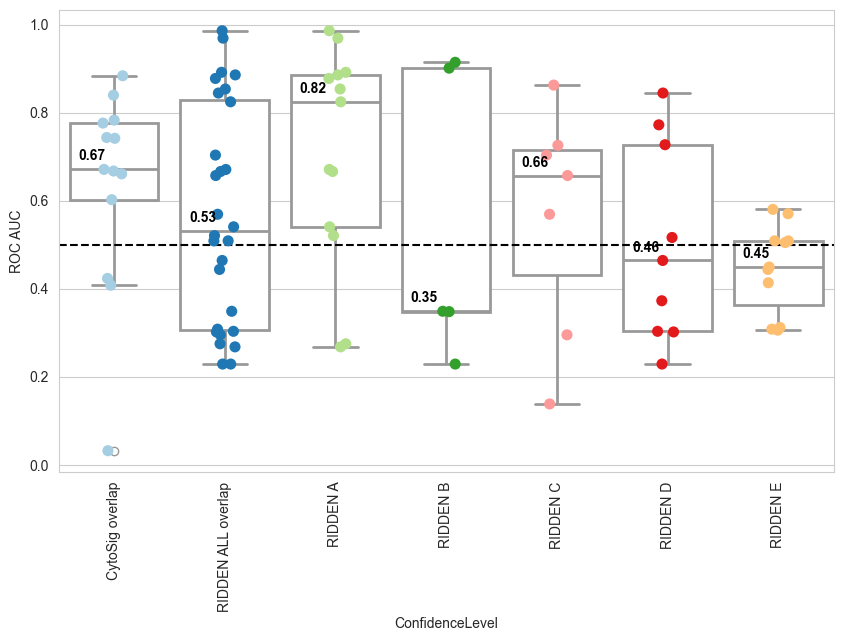

In [158]:
plt.figure(figsize=(10, 6))
boxp = sns.boxplot(x='ConfidenceLevel', y='ROC AUC', data=rocauc_results_all_immunedict, color = 'white', linewidth=2, order = ['CytoSig overlap', 'RIDDEN ALL overlap', 'RIDDEN A', 'RIDDEN B', 'RIDDEN C', 'RIDDEN D', 'RIDDEN E'])
sns.stripplot(x='ConfidenceLevel', y='ROC AUC', data=rocauc_results_all_immunedict, palette = 'Paired', size = 8, order = ['CytoSig overlap', 'RIDDEN ALL overlap', 'RIDDEN A', 'RIDDEN B', 'RIDDEN C', 'RIDDEN D', 'RIDDEN E'])
add_median_labels(boxp)
plt.ylabel('ROC AUC')
plt.xticks(rotation = 90)
plt.axhline(0.5, color = 'k', linestyle = '--')
plt.show()

In [159]:
# rocauc_results_all_immunedict.to_csv(f'results/revision/immunedict_lincs_rocauc_filtered_without_ligandperturbations.csv')

# Figure

In [160]:
import matplotlib.colors as mcolors


In [161]:
sns.set_style("whitegrid")
hex_colors = [mcolors.rgb2hex(color) for color in sns.color_palette('Blues', 5)]

colors = [hex_colors[3], '#808080', hex_colors[1] , hex_colors[1], hex_colors[1], hex_colors[1], hex_colors[1]]
custom_palette2 = sns.color_palette(colors)

In [162]:
def add_median_labels(ax, fmt='.2f'):
    lines = ax.get_lines()
    boxes = [c for c in ax.get_children() if type(c).__name__ == 'PathPatch']
    lines_per_box = int(len(lines) / len(boxes))
    for median in lines[4:len(lines):lines_per_box]:
        x, y = (data.mean() for data in median.get_data())
        # choose value depending on horizontal or vertical plot orientation
        value = x if (median.get_xdata()[1] - median.get_xdata()[0]) == 0 else y
        text = ax.text(x, y+0.03, f'{value:{fmt}}', ha='center', va='center',
                       fontweight='bold', color='black')

In [163]:
def benchmark_result_boxplot(results:pd.DataFrame, save = False, filepath = '', filename = '', order = [ 'RIDDEN ALL', 'RIDDEN A', 'RIDDEN B', 'RIDDEN C', 'RIDDEN D','RIDDEN E', 'CytoSig'], figsize_x = 4, palette = custom_palette):
    fig, ax = plt.subplots(figsize = (figsize_x,3.5), facecolor='white')
    boxp = sns.boxplot(x='ConfidenceLevel', y='ROC AUC', data=results, color = 'white', linewidth=2, order = order)
    scp = sns.stripplot(x='ConfidenceLevel', y='ROC AUC', data=results, palette = palette, size = 5, order= order)
    add_median_labels(boxp)
    plt.xlabel('Model', fontsize = 14)
    plt.ylabel('ROC AUC', fontsize = 14)
    plt.axhline(0.5, color = 'grey', linestyle = '--', alpha = 0.8)
    plt.xticks(fontsize =12, rotation = 90)
    plt.yticks(fontsize =12)
    plt.ylim(0,1)

    if save:
        if filename=='': raise "No filename was given."
        plt.savefig(f'{filepath}/{filename}.png', dpi = 350, bbox_inches = 'tight', transparent = False)
        plt.savefig(f'{filepath}/{filename}.jpg', dpi = 350, bbox_inches = 'tight', transparent = False)
        plt.savefig(f'{filepath}/{filename}.pdf', bbox_inches = 'tight', transparent = True)

In [164]:
rocauc_results_all_immunedict.groupby('ConfidenceLevel').median().sort_values(by = 'ROC AUC', ascending = False)

,ROC AUC
ConfidenceLevel,
RIDDEN A,0.824463
CytoSig overlap,0.670893
RIDDEN C,0.656977
RIDDEN ALL overlap,0.530480
RIDDEN D,0.464069
RIDDEN E,0.449153
RIDDEN B,0.348616


/var/folders/ld/gy00m33j1pn81v2x1sj_h3pm0000gn/T/ipykernel_23188/3767089349.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  scp = sns.stripplot(x='ConfidenceLevel', y='ROC AUC', data=results, palette = palette, size = 5, order= order)


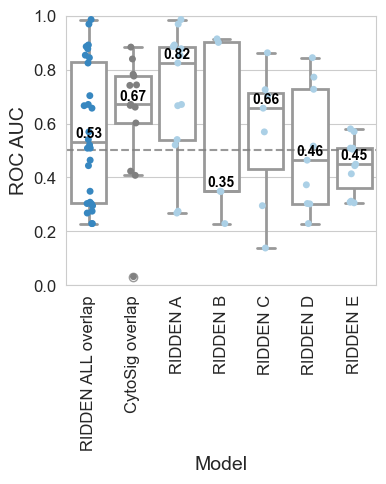

In [165]:
benchmark_result_boxplot(rocauc_results_all_immunedict, save = True, filepath = f'figures/revision', filename = f'RIDDEN_without_ligand_on_immunedict', 
                         order = [ 'RIDDEN ALL overlap', 'CytoSig overlap', 'RIDDEN A', 'RIDDEN B', 'RIDDEN C', 'RIDDEN D','RIDDEN E'], 
                         palette = custom_palette2)